In [2]:
import binascii
import gzip
import json
import os
import sys
import re

from io import BytesIO

import pandas as pd
import numpy as np
import json
import altair as alt
import math

from glob import glob

from Bio import SeqIO
from IPython.display import HTML
from onecodex.notebooks.report import set_style, title
import onecodex
from pathlib import Path

import matplotlib.pyplot as plt
import dnaplotlib as dpl
from matplotlib import gridspec
#from pylab import *
import matplotlib.ticker as mticker
from IPython.display import Image

In [3]:
def read_vcf_as_dataframe(path):
    df = pd.read_csv(
        path,
        sep="\t",
        comment="#",
        names=["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"],
        usecols=[0, 1, 2, 3, 4, 5, 6, 7],
    )

    # parse info add key/value items to data-frame
    info_data = []
    for row in df["INFO"].values:
        items = [i.split("=") for i in row.split(";")]
        parsed = {}
        for item in items:
            # boolean items. skip for now
            if len(item) == 1:
                pass
            elif len(item) == 2:
                parsed[item[0]] = item[1]
            else:
                raise Exception(f"Item of unexpected length in vcf info column: {item}")

        if "DP4" in parsed.keys():
            depth_column = "DP4"
        elif "SR" in parsed.keys():
            depth_column = "SR"
        else:
            raise Exception("Cannot determine 4x depth column")

        # parse depth column into ALT and REF depths
        depths = [int(x) for x in parsed[depth_column].split(",")]
        parsed["ALT_DP"] = sum(depths[2:])
        parsed["REF_DP"] = sum(depths[:2])
        info_data.append(parsed)

    df = pd.DataFrame([{**r, **i} for r, i in zip(df.to_dict(orient="records"), info_data)])

    return df

In [4]:
onecodex.Api() # initialize plot embedding
pass # don't print anything

In [5]:
RESULTS_DIR = Path(os.environ.get("RESULTS_DIR", os.getcwd()))

In [6]:
INSTRUMENT_VENDOR = os.getenv("INSTRUMENT_VENDOR", "Illumina")

if INSTRUMENT_VENDOR == 'Illumina':
    MIN_DEPTH = 10
elif INSTRUMENT_VENDOR == 'Oxford Nanopore':
    MIN_DEPTH= 50
else:
    raise Exception(f"Invalid sequencing platform: ${INSTRUMENT_VENDOR}")

SAMPLE_PATH = os.environ["SAMPLE_PATH"] or glob("*.fastq.gz")[0]

# outputs of bioinformatics pipeline (default paths)
VARIANTS_VCF_PATH = RESULTS_DIR / "variants.vcf"
NEXTCLADE_JSON = RESULTS_DIR / "nextclade.json"
NEXTCLADE_TSV_PATH = RESULTS_DIR / "nextclade.tsv"
PANGOLIN_CSV_PATH = RESULTS_DIR / "pangolin.csv"
CONSENSUS_PATH = RESULTS_DIR / "consensus.fa"
SNPS_DEPTH_PATH = RESULTS_DIR / "snps.depth"


# databases
REFERENCE_PATH = os.environ.get("FASTA_REFERENCE", "/share/nCoV-2019.reference.fasta")

In [7]:
# yes this is slow but it doesn't require an API call
# (but it would be nice to not need the fastq as this point maybe. maybe this is in the bam file?)
total_reads = 0
with gzip.open(SAMPLE_PATH, "rt") as handle:
    for line in handle:
        total_reads += 1
total_reads = total_reads / 4

In [8]:
# load reference genome
reference = list(SeqIO.parse(CONSENSUS_PATH, "fasta"))
reference_length = len(reference[0])

In [9]:
warning_messages = []

In [10]:
# TODO: generate before
with open(RESULTS_DIR / "total_mapped_reads.txt") as handle:
    total_mapped_reads = int(handle.read())

In [11]:
depth_table = []

with open(SNPS_DEPTH_PATH) as handle:
    for line in handle:
        row = line.strip().split("\t")
        if len(row) == 1:
            continue
        depth_table.append(
            {"reference": row[0], "position": int(row[1]), "depth": int(row[2])}
        )
depth_table = pd.DataFrame(depth_table, columns=["reference", "position", "depth"])


In [12]:
# Calculate genome coverage (what percent of bases are coveraged at X coverage)
# Use a fixed reference length that we use for `samtools depth` above

covered_sites = set()
covered_sites_mindepth = set()

for _, row in depth_table.iterrows():
    row = row.to_dict()
    if row["depth"] >= 1:
        covered_sites.add(row["position"])
    if row["depth"] >= MIN_DEPTH:
        covered_sites_mindepth.add(row["position"])

cov = len(covered_sites) / reference_length
if cov <= 0.9:
    warning_messages.append(
        "The consensus sequence is too incomplete for GISAID submission (reads must span >90% of the reference)."
    )
cov_mindepth = len(covered_sites_mindepth) / reference_length

In [13]:
# get mean over windows because altair can't handle > 5k points ...
binned_depths = []
window_width = reference_length // 4500

for i in range(1, reference_length, window_width):
    window = depth_table.loc[
        (depth_table["position"] > i) & (depth_table["position"] < i + window_width)
    ]

    binned_depths.append(
        {"position": i, "depth": window["depth"].mean(),}
    )

binned_depths = pd.DataFrame(binned_depths)
# Convert position from bp to kbp, to improve how the coverage plot looks
binned_depths["position"] = binned_depths["position"]/1000
mean_depth = depth_table["depth"].mean() if not depth_table.empty else 0
median_depth = depth_table["depth"].median() if not depth_table.empty else 0

In [14]:
# Read Nextclade and Pangolin tables

if not os.path.exists(PANGOLIN_CSV_PATH):
    warning_messages.append("No pangolin output")
    have_pangolin = False
else:
    have_pangolin = True
    pangolin_table = pd.read_csv(PANGOLIN_CSV_PATH, sep=",")

In [15]:
# Read nextclade JSON
##### Please note that everything in the Nextclade JSON (nt positions, ranges, codon positions) is 0-indexed,
##### but SARS-CoV-2 variants (and most things) are reported as 1-indexed.

with open(NEXTCLADE_JSON) as json_file:
    nextclade_json = json.load(json_file)
    assert len(nextclade_json) == 1, f"expected exactly 1 result in: {nextclade_json}"
    nextclade_json = nextclade_json[0]

In [16]:
if len(nextclade_json["errors"]) > 0:
    have_nextclade = False
    nextclade_lineage = None
    warning_messages.extend(nextclade_json["errors"])
    n_snps_mindepth = None
    n_snps = None
    nextclade_pm_count = None
elif len(nextclade_json['substitutions']) == 0:
    warning_messages.append("No variants detected")
    have_nextclade = True
    nextclade_lineage = None
    n_snps_mindepth = 0
    n_snps = 0
    nextclade_pm_count = 0
else:
    have_nextclade = True

    # Generate warnings if indels are detected? (ONT does not reliably detect these)
    if INSTRUMENT_VENDOR == "Oxford Nanopore":
        if nextclade_json["insertions"] != [] or nextclade_json["deletions"] != []:
            warning_messages.append("Indels were detected (ONT cannot reliably detect these).")

    # load nextclade JSON
    rows_list = []
    for subst in nextclade_json["substitutions"]:  # Each substitution is a dictionary
        dict1 = {}
        dict1["Position"] = (
            subst["pos"] + 1
        )  # JSON positions are 0-indexed; convert to 1-index
        dict1["Ref"] = subst["refNuc"]
        dict1["Alt"] = subst["queryNuc"]
        if len(subst["aaSubstitutions"]) != 0:
            for mutation in subst[
                "aaSubstitutions"
            ]:  # JSON codons are 0-indexed; convert to 1-index
                dict1["Amino acid mutation"] = (
                    mutation["refAA"] + str(mutation["codon"] + 1) + mutation["queryAA"]
                )
        else:
            dict1["Amino acid mutation"] = ""
        rows_list.append(dict1)

    df_nextclade = pd.DataFrame(rows_list)
    # in case mutations are outside of Genes
    df_nextclade['Gene'] = '-'
    
    # load variants VCF
    df_vcf = read_vcf_as_dataframe(VARIANTS_VCF_PATH)
    
    # Add in gene info
    df_orfs = pd.read_csv(
        "./annot_table.orfs.txt",
        sep="\t",
        header=None,
        usecols=[0, 1, 2],
        names=["gene", "start", "stop"],
    )
    
    # Add in low-complexity region info
    df_low_complexity = pd.read_csv(RESULTS_DIR / "low_complexity_regions.txt", sep="\t", header=None, usecols=[1,2], names=["start","stop"])
    
    # join nextclade, VCF data and ORF annotations
    # Add in a flag if variant is in a low-complexity region
    
    for i in df_nextclade.index:
        for j in df_orfs.index:
            if (
                df_orfs.loc[j, "start"]
                <= df_nextclade.loc[i, "Position"]
                <= df_orfs.loc[j, "stop"]
            ):
                df_nextclade.loc[i, "Gene"] = df_orfs.loc[j, "gene"]
        for k in df_low_complexity.index:
            if (
                df_low_complexity.loc[k, "start"]
                <= df_nextclade.loc[i, "Position"]
                <= df_low_complexity.loc[k, "stop"]
            ):
                df_nextclade.loc[i, "Low complexity region"] = "X"
            else:
                df_nextclade.loc[i, "Low complexity region"] = ""

    # df_nextclade in depth info
    variant_table = df_nextclade.set_index("Position")

    df_vcf["TOT_DP"] = df_vcf["REF_DP"] + df_vcf["ALT_DP"]
    
    # Check that the same variant is always called from both amplicons spanning a position
    df_vcf = df_vcf.reset_index()
    df_dup = df_vcf[df_vcf["POS"].duplicated(keep=False)]
    for i in np.unique(df_dup["POS"]):
        alt_list = df_dup[df_dup["POS"]==i]["ALT"].tolist()
#        display(i,alt_list)
#        assert {all(element == alt_list[0] for element in alt_list)} == {True}

        
    # sum depths between multiple pools
    summed = (
        df_vcf[["POS", "REF_DP", "ALT_DP", "TOT_DP"]]
        .groupby("POS")
        .agg(sum)
    )

    summed["Alt frequency (%)"] = (
        summed["ALT_DP"] / (summed["ALT_DP"] + summed["REF_DP"]) * 100
    )

    pd.options.display.float_format = "{:,.2f}".format
    variants_table = variant_table.merge(
        summed, left_index=True, right_index=True, how="left"
    )
    
    display_columns = [
        "Ref",
        "Alt",
        "Alt depth",
        "Total depth",
        "Alt frequency (%)",
        "Gene",
        "Amino acid mutation",
    ]
    
    if INSTRUMENT_VENDOR == "Oxford Nanopore":
        display_columns.append("Low complexity region")

    variants_table = variants_table.rename(
        columns={
            "REF": "Ref",
            "ALT": "Alt",
            "ALT_DP": "Alt depth",
            "TOT_DP": "Total depth",
        }
    )[display_columns]

    n_snps = variants_table.shape[0]
    n_snps_mindepth = sum(variants_table["Total depth"] > MIN_DEPTH)

    nextclade_pm_count = nextclade_json["qc"]["privateMutations"]["total"]
    nextclade_lineage = nextclade_json["clade"]

In [17]:

if have_pangolin:
    pangolin_lineage = pangolin_table["lineage"].iloc[0]
    pangolin_version = pangolin_table["pangoLEARN_version"].iloc[0]
    
    # Do not assign a Pangolin or Nextclade lineage if consensus does not pass QC
    
    for record in SeqIO.parse(CONSENSUS_PATH, "fasta"):
    
        if record.seq.count("N") > 20000:
            pangolin_lineage="unassigned"
            nextclade_lineage="unassigned"
            warning_messages.append(
                "The consensus sequence has too many ambiguous bases: "
                + str(record.seq.count("N"))
                + f" N's against the {reference_length} base reference sequence."
            )
        # Split contig into unambiguous stretches
        runs = re.split(
            r"[^ATGC]", str(record.seq)
        )  
        max_len = len(max(runs, key=len))  # Length of longest unambiguous stretch

        if max_len < 10000:
            pangolin_lineage="Cannot be confidently assigned"
            nextclade_lineage="Cannot be confidently assigned"
            warning_messages.append(
                "The consensus sequence is too incomplete for GISAID submission: the longest stretch of unambiguous bases is only "
                + str(max_len)
                + " bases (must be over 10,000)."
            )
        
else:
    warning_messages.append("Pangolin failed")
    pangolin_lineage = "Undetected or error"
    pangolin_version = "NA"



In [18]:
title("SARS-CoV-2 (COVID-19) Sequencing Overview")

In [19]:
text = []

text.append(f"""
<p>
This report summarizes the detection of SARS-CoV-2 single-nucleotide variants (SNVs) in sample 
<strong>{os.path.basename(SAMPLE_PATH)}</strong> generated on the <strong>{INSTRUMENT_VENDOR}</strong> sequencing platform.
</p>
""")

if INSTRUMENT_VENDOR == "Oxford Nanopore":
    text.append(f"""
    <p>A minimum depth of {MIN_DEPTH}x was chosen for confident SNV detection based on 
    <a href="https://doi.org/10.1038/s41467-020-20075-6">benchmarking</a> of SARS-CoV-2 sequencing data.
    
    SNV detection in low complexity regions (ex: homopolymer-rich) is less accurate and flagged in the table below.
    This benchmarking study also concludes that Oxford Nanopore sequencing is unsuitable for detection of small indel varants,
    which we do not report here.
    </p>
    """)
elif INSTRUMENT_VENDOR == "Illumina":
    text.append(f"""
    <p>A minimum depth of {MIN_DEPTH}x was chosen for confident SNV detection using Illumina sequencing data.</p>
    """)
    
    
text.append(f"""
<p>This sample contained <strong>{int(total_reads):,}</strong> reads, with
<strong>{total_mapped_reads / total_reads:.1%}</strong> mapping to the 
<a href='https://www.ncbi.nlm.nih.gov/nuccore/MN908947.3/' target='_blank'>Wuhan-Hu-1 reference</a>.
Reads span <strong>{cov:.0%}</strong> of the genome, with a mean depth of <strong>{mean_depth:.0f}x</strong>, and {cov_mindepth:.0%} of the genome covered at depths >{MIN_DEPTH:}x.
</p>
""")

text.append(f"""
<p>A total of <strong>{n_snps_mindepth}</strong> SNV{'s were' if n_snps_mindepth != 1 else 'was'} detected 
at depths >{MIN_DEPTH:}x</p>
""")

if pangolin_lineage == "Cannot be confidently assigned":
    text.append(f"""<p>The genome quality is too low to confidently assign a Pangolin or Nextclade lineage (see warning messages).</p>""")
else:
    text.append(f"""
<p>This genome is classified as Pangolin lineage <strong>{pangolin_lineage}</strong> using PangoLEARN
version {pangolin_version} and Nextclade lineage <strong>{nextclade_lineage}</strong> with {nextclade_pm_count} 
private mutation{'s' if nextclade_pm_count != 1 else ''}.
</p>
""")

HTML("".join(text))

In [20]:
# Coverage plot
reference_length_kb = reference_length // 1000

plot = (
    alt.Chart(binned_depths)
    .mark_area()
    .transform_window(rolling_mean="mean(depth)", frame=[-50, 50])
    .encode(
        x=alt.X(
            "position",
            title="Genomic Coordinate (kb)",
            scale=alt.Scale(domain=[0, reference_length_kb]),
        ),
        y=alt.Y("rolling_mean:Q", scale=alt.Scale(type="linear"), title="Depth"),
    )
    .properties(
        title=f"SARS-CoV-2",
        width=550,
        height=150,
    )
)
plot

alt.Chart(...)

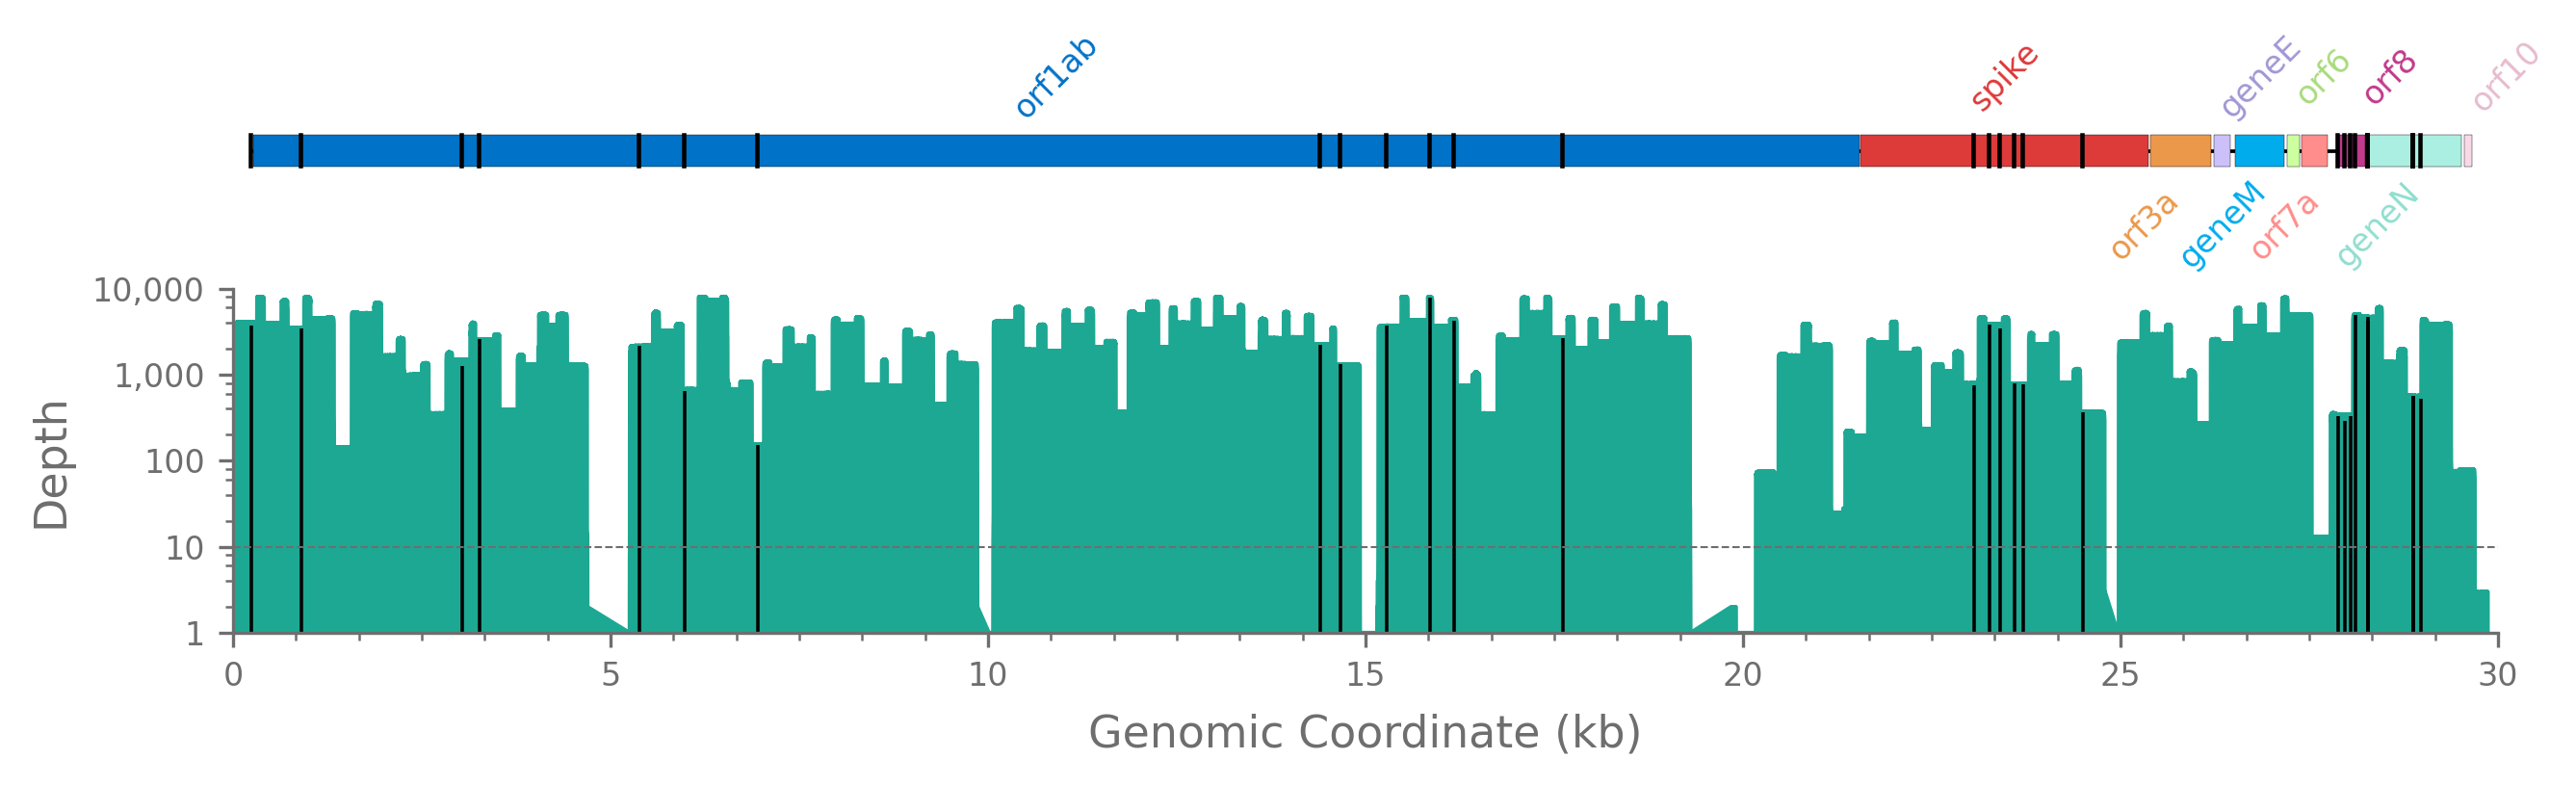

In [29]:
#######################

# Un-smoothed coverage plot in matplotlib

#######################

    
############### Define genome diagram design 

cur_region = [0, 30000]

# Colors
col_map = {}
col_map['grey'] = "#6e6e6e"
col_map['ocx_signature_green'] = "#128887"
col_map['ocx_navy_blue'] = "#16347B"
col_map['ocx_blue'] = "#0072C7"
col_map['ocx_light_blue'] = "#01ACEC"
col_map['ocx_cyan'] ="#97E9FC"
col_map['ocx_forest_green'] = "#0A605E"
col_map['ocx_kelly_green'] = "#1DA893"
col_map['ocx_blue_green'] = "#3DD8BE"
col_map['ocx_pastel_green'] = "#ABEFE2"
col_map['ocx_dark_purple'] = "#37257D"
col_map['ocx_purple'] = "#9C78E0"
col_map['ocx_pastel_purple'] = "#CBC0F9"
col_map['ocx_light_purple'] = "#E3DDFF"
col_map['ocx_burnt_sienna'] = "#BC5B00"
col_map['ocx_orange'] = "#EB984A"
col_map['ocx_yellow'] = "#FCE34D"
col_map['ocx_light_yellow'] = "#FEF2A3"
col_map['ocx_dark_red'] = "#950303"
col_map['ocx_red'] = "#DD3A3A"
col_map['ocx_coral'] = "#FF8D8B"
col_map['ocx_peach'] = "#FFD5CB"
col_map['ocx_dark_magenta'] = "#771354"
col_map['ocx_magenta'] = "#C13A8B"
col_map['ocx_pink'] = "#F28BBF"
col_map['ocx_light_pink'] = "#F9D9E7"

# dnaplotlib formatting options

# Some additional parameters that can be set:
# 'label_style':'italic'
# 'linewidth':1.0
# 'arrowhead_length':8,

Y_OFFSET=7
LABEL_ROTATION=45
LABEL_SIZE=8 # font size
LINEWIDTH=0.1
LINECOLOR="#3b3b3b"
SNP_LINEWIDTH=0.85
EDGE_COLOR=col_map['ocx_red']

opt_orf1ab = { 'label':'orf1ab', 'label_color':col_map['ocx_blue'], 'label_y_offset':Y_OFFSET, \
              'color':col_map['ocx_blue'], 'label_rotation':LABEL_ROTATION, 'label_size':LABEL_SIZE, \
             'linewidth':LINEWIDTH, 'linecolor':LINECOLOR, 'edgecolor':EDGE_COLOR }
opt_spike = { 'label':'spike', 'label_color':col_map['ocx_red'], 'label_y_offset':Y_OFFSET, \
             'color':col_map['ocx_red'], 'label_rotation':LABEL_ROTATION, 'label_size':LABEL_SIZE, \
            'linewidth':LINEWIDTH, 'linecolor':LINECOLOR, 'edgecolor':EDGE_COLOR }
opt_orf3a = {'label':'orf3a', 'label_color':col_map['ocx_orange'], 'label_y_offset':-Y_OFFSET, \
             'color':col_map['ocx_orange'], 'label_rotation':LABEL_ROTATION, 'label_size':LABEL_SIZE, \
            'linewidth':LINEWIDTH, 'label_x_offset':-500, 'edgecolor':EDGE_COLOR }
opt_geneE = {'label':'geneE', 'label_color':"#a296d6", 'label_y_offset':Y_OFFSET, \
             'color':col_map['ocx_pastel_purple'], 'label_rotation':LABEL_ROTATION, 'label_size':LABEL_SIZE, \
            'linewidth':LINEWIDTH, 'label_x_offset':500, 'edgecolor':EDGE_COLOR }
opt_geneM = {'label':'geneM', 'label_color':col_map['ocx_light_blue'], 'label_y_offset':-Y_OFFSET, \
             'color':col_map['ocx_light_blue'], 'label_rotation':LABEL_ROTATION, 'label_size':LABEL_SIZE, \
            'linewidth':LINEWIDTH, 'label_x_offset':-500, 'edgecolor':EDGE_COLOR }
opt_orf6 = {'label':'orf6', 'label_color':"#a9db7d", 'label_y_offset':Y_OFFSET, \
            'color':"#cdffa1", 'label_rotation':LABEL_ROTATION, 'label_size':LABEL_SIZE, \
           'linewidth':LINEWIDTH, 'label_x_offset':400, 'edgecolor':EDGE_COLOR }
opt_orf7a = {'label':'orf7a', 'label_color':col_map['ocx_coral'], 'label_y_offset':-Y_OFFSET, \
             'color':col_map['ocx_coral'], 'label_rotation':LABEL_ROTATION, 'label_size':LABEL_SIZE, \
            'linewidth':LINEWIDTH, 'label_x_offset':-400, 'edgecolor':EDGE_COLOR }
opt_orf8 = {'label':'orf8', 'label_color':col_map['ocx_magenta'], 'label_y_offset':Y_OFFSET, \
            'color':col_map['ocx_magenta'], 'label_rotation':LABEL_ROTATION, 'label_size':LABEL_SIZE, \
           'linewidth':LINEWIDTH, 'label_x_offset':500, 'edgecolor':EDGE_COLOR }
opt_geneN = {'label':'geneN', 'label_color':'#90decf', 'label_y_offset':-Y_OFFSET, \
             'color':col_map['ocx_pastel_green'], 'label_rotation':LABEL_ROTATION, 'label_size':LABEL_SIZE, \
            'linewidth':LINEWIDTH, 'label_x_offset':-500, 'edgecolor':EDGE_COLOR }
opt_orf10 = {'label':'orf10', 'label_color':"#e6bcce", 'label_y_offset':Y_OFFSET, \
             'color':col_map['ocx_light_pink'], 'label_rotation':LABEL_ROTATION, 'label_size':LABEL_SIZE, \
            'linewidth':LINEWIDTH, 'label_x_offset':500, 'edgecolor':EDGE_COLOR }
opt_snv = { 'color':'black' , 'linewidth':SNP_LINEWIDTH }

# Define ORFs (if want arrows instead of blocks, switch to 'type':'CDS')
ORF1AB = {'type':'UserDefined', 'name':'orf1ab', 'start':266,  'end':21555, 'fwd':True, 'opts':opt_orf1ab}
SPIKE = {'type':'UserDefined', 'name':'spike', 'start':21563, 'end':25384, 'fwd':True, 'opts':opt_spike}
ORF3A = {'type':'UserDefined', 'name':'orf3a', 'start':25393, 'end':26220, 'fwd':True, 'opts':opt_orf3a}
GENEE = {'type':'UserDefined', 'name':'geneE', 'start':26245, 'end':26472, 'fwd':True, 'opts':opt_geneE}
GENEM = {'type':'UserDefined', 'name':'geneM', 'start':26523, 'end':27191, 'fwd':True, 'opts':opt_geneM}
ORF6 = {'type':'UserDefined', 'name':'orf6', 'start':27202, 'end':27387, 'fwd':True, 'opts':opt_orf6}
ORF7A = {'type':'UserDefined', 'name':'orf6', 'start':27394, 'end':27759, 'fwd':True, 'opts':opt_orf7a}
ORF8 = {'type':'UserDefined', 'name':'orf8', 'start':27894, 'end':28259, 'fwd':True, 'opts':opt_orf8}
GENEN = {'type':'UserDefined', 'name':'geneN', 'start':28274, 'end':29533, 'fwd':True, 'opts':opt_geneN}
ORF10 = {'type':'UserDefined', 'name':'orf10', 'start':29558, 'end':29674, 'fwd':True, 'opts':opt_orf10}

# A design is merely a list of parts and their properties
design = [ORF1AB, SPIKE, ORF3A, GENEE, GENEM, ORF6, ORF7A, ORF8, GENEN, ORF10]

# Add SNVs to the design
for position, row in variants_table.iterrows():
    START=position
    END=position+1
    design.append({'type':'UserDefined', 'name':'snv', 'start':START,  'end':END, 'fwd':True, 'opts':opt_snv})


################# Plot genome diagram

# Create the overall figure
fig = plt.figure(figsize=(8,2), dpi=300)
gs = gridspec.GridSpec(2, 1, height_ratios=[0.4, 1])

# Create the DNAplotlib renderer
dr = dpl.DNARenderer(scale=15, linewidth=0.9)

# Render the orfs to axis
ax_dna = plt.subplot(gs[0])
start, end = dr.renderDNA(ax_dna, design, dr.trace_part_renderers(), plot_backbone=True)
ax_dna.set_xlim(cur_region)
ax_dna.set_ylim([-5,8])
ax_dna.axis('off')


################# Plot coverage

# Generate axes for coverage plot
ax = plt.subplot(gs[1])


###### x-axis

ax.set_xlim(cur_region)
ax.set_xlabel('Genomic Coordinate (kb)', fontsize=11, labelpad=5)

# Set x-axis ticks to kb
labels = ax.get_xticks().tolist()
labels_kb = [int(float(label)/1000) for label in labels]
ax.set_xticklabels(labels_kb)

# Set 5 minor ticks per major tick
from matplotlib.ticker import AutoMinorLocator
minor_locator = AutoMinorLocator(6)
ax.xaxis.set_minor_locator(minor_locator)

###### y-axis

ax.set_ylabel('Depth', fontsize=11, labelpad=5)

# Set y-axis limits according to maximum depth in sample
ax.set_yscale('log')
exp = math.ceil(math.log10(depth_table['depth'].max()))
yaxis_max = 10**exp
ax.set_ylim((1,yaxis_max))

# y-axis major ticks at every multiple of 10
locmaj = mticker.LogLocator(base=10, numticks=20) # numticks should be > number of ticks to display
ax.yaxis.set_major_locator(locmaj)

# y-axis major tick labels: commas at thousands
import warnings # attempt to avoid printing "FixedFormatter should only be used together with FixedLocator"
warnings.filterwarnings("ignore") # This only works sometimes...
ax.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# y-axis minor ticks (5 per major tick)
locmin = mticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=20)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mticker.NullFormatter())


##### axis colors and spine visiblity

# Set axis colors to grey; show only the bottom and left spines
for SPINE in ['bottom', 'left']:
    ax.spines[SPINE].set_color(col_map['grey'])
for SPINE in ['right', 'top']:
    ax.spines[SPINE].set_visible(False)
for AXIS in ['x', 'y']:
    ax.tick_params(axis=AXIS, which='both', colors=col_map['grey'], labelsize=8)
ax.yaxis.set_ticks_position('left')
ax.yaxis.label.set_color(col_map['grey'])
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.label.set_color(col_map['grey'])


##### Plot depths as a colored fill
plt.fill_between(depth_table['position'], depth_table['depth'], color=col_map['ocx_kelly_green'])

# If we really want to see single nt positions with low coverage,
# we should plot the depths as white over a colored fill
#plt.plot(depth_table['position'], depth_table['depth'], color=col_map['ocx_kelly_green'], linestyle='solid', linewidth=0.1)
#plt.fill_between(depth_table['position'], depth_table['depth']-10, color=col_map['ocx_kelly_green'])

##### Show min depth as grey dashed line
plt.hlines(y=MIN_DEPTH, xmin=0, xmax=30000, linestyle='--', linewidth=0.5, color=col_map['grey'])

##### Show SNVs and color according to AA mutation
for position, row in variants_table.iterrows():
    yvalue = depth_table.loc[depth_table['position'] == position, 'depth'].iloc[0]
    xvalue = np.arange(position-0.45, position+0.45)
    plt.fill_between(xvalue, yvalue, color="black", linewidth=SNP_LINEWIDTH)
    
    
############# Update subplot spacing

plt.subplots_adjust(hspace=0.35, left=0.01, right=0.99, top=0.99, bottom=0.01)

############# Close and save

plt.close()
#plt.show()

fig.savefig("covplot.png", bbox_inches='tight', dpi=300)
Image("covplot.png")

In [22]:
if n_snps_mindepth is None:
    display(HTML("Nextclade Error. See Warnings below."))
elif n_snps_mindepth > 0: # If there are variants
    display(variants_table[variants_table['Total depth'] > MIN_DEPTH])
    legend_text = "SARS-CoV-2 variants."

    n_extra_variants = (
        sum(variants_table["Total depth"] > MIN_DEPTH) if not variant_table.empty else 0
    )

    if n_extra_variants > 0:
        legend_text += f" An additional {n_extra_variants} variant{'s' if n_extra_variants > 1 else ''} <{MIN_DEPTH}× depth {'are' if n_extra_variants > 1 else 'is'} not shown."


    if os.environ.get("ONE_CODEX_REPORT_UUID"):
        legend_text += f""" 
             A variants TSV and consensus FASTA is available <a target="_blank" href=\"{'https://app.onecodex.com/report/' + os.environ['ONE_CODEX_REPORT_UUID'] + '/files'}\">here</a>.
            """
    display(HTML(
        '<div style="text-align: center; padding-top: 10px; font-size: 0.7em; color: #777;"><em>'
        + legend_text
        + "</em></div>"
    ))
else:
    HTML(f"No variants detected > {MIN_DEPTH}-x depth")

,Ref,Alt,Alt depth,Total depth,Alt frequency (%),Gene,Amino acid mutation
Position,,,,,,,
241,C,T,369.00,371.00,99.46,-,
913,C,T,385.00,393.00,97.96,nsp2 in orf1ab,
3037,C,T,346.00,347.00,99.71,nsp3 in orf1ab,
3267,C,T,376.00,382.00,98.43,nsp3 in orf1ab,T1001I
5388,C,A,395.00,396.00,99.75,nsp3 in orf1ab,A1708D
5986,C,T,375.00,380.00,98.68,nsp3 in orf1ab,
6954,T,C,151.00,154.00,98.05,nsp3 in orf1ab,I2230T
14408,C,T,356.00,364.00,97.80,nsp12 in orf1ab,P314L
14676,C,T,388.00,395.00,98.23,nsp12 in orf1ab,


### Additional Resources

- Additional bioinformatics pipeline details are [available on GitHub](https://github.com/onecodex/sars-cov-2)
- [Nextstrain](https://nextstrain.org/ncov) maintains an up-to-date analysis of SARS-CoV-2 (HCoV-19).
- The [Global Initiative on Sharing All Influenza Data (GISAID)](https://www.gisaid.org/) hosts viral genomes from ongoing outbreaks. Please [contact us](mailto:hello@onecodex.com) for help submitting your data.

In [23]:
# Add One Codex report ID to footer for reproducibility/data provenance (not yet in v0.7.2)
HTML(
    f"""
<style type='text/css'>
@page {{
    @bottom-center {{
        content: "{os.environ['ONE_CODEX_REPORT_UUID'] + ' -' if os.environ.get('ONE_CODEX_REPORT_UUID') else ''} NOT FOR DIAGNOSTIC USE" !important;
    }}
}}
</style>
"""
)

In [24]:
# Save a JSON too, including filtered variants <50x
results = {
    "n_reads": total_reads,
    "n_mapped_reads": total_mapped_reads,
    "report_id": os.environ.get("ONE_CODEX_REPORT_UUID"), 
    "sample_id": os.environ.get("ONE_CODEX_SAMPLE_UUID"),
    "variants": variants_table.to_dict(orient='records') if n_snps else None,
    "coverage": cov,
    "coverage_over_min_depth": cov_mindepth,
    "min_depth": MIN_DEPTH,
    "mean_depth": mean_depth,
    "median_depth": median_depth,
    "nextclade_results": nextclade_json,
    "nextclade_lineage": nextclade_lineage,
    "pangolin_results": pangolin_table.to_dict(orient='records'),
    "pangolin_lineage": pangolin_lineage,
    "warnings": warning_messages,
}

with gzip.open(f"{os.path.basename(SAMPLE_PATH)}.report.json.gz", "w") as f:
    f.write(json.dumps(results).encode())

In [25]:
if len(warning_messages) > 0:
    display(HTML("<ul>"))
    display(HTML("<h1>Warning Messages</h1>"))    
    for message in warning_messages:
        display(HTML(f"<li>{message}</li>"))
    display(HTML("</ul>"))